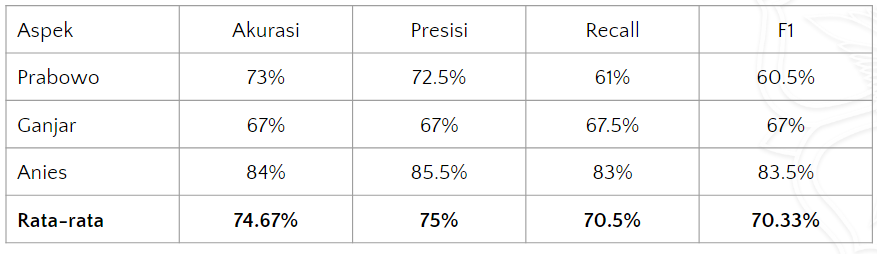**Aspect-Based Sentiment Analysis untuk Mengetahui Reaksi Masyarakat Terhadap Capres pada Kolom Komentar YouTube**

#Scraping Komentar Youtube

In [ ]:
# Import Library untuk Scrape Komentar Youtube

!pip install furl
from google.colab import files
import pandas as pd
import googleapiclient.discovery
from furl import furl
import re

In [ ]:
# Video URL
VIDEO_URL = 'https://www.youtube.com/watch?v=C2aZPjVdqyA'
MAX_COMMENTS = 100 * 100

# Dapatkan API Key dari https://console.cloud.google.com/marketplace/product/google/youtube.googleapis.com?project=optical-depth-236613
API_SERVICE_NAME = "youtube"
API_VERSION = "v3"
API_KEY = 'CHANGE_API_KEY'

def get_video_id(video_url):
    if len(video_url):
        f = furl(video_url)
        if len(f.args) and 'v' in list(f.args.keys()):
            return f.args['v']
    return None

def get_youtube_client():
    return googleapiclient.discovery.build(
        API_SERVICE_NAME, API_VERSION, developerKey = API_KEY)

def get_comments_by_video(video_id, nextPageToken=None):
    request = get_youtube_client().commentThreads().list(
        part="snippet,replies",
        videoId=video_id,
        maxResults=100,
        pageToken=nextPageToken
    )
    return request.execute()

def get_all_comments(video_id, max_comments):
    comments_list = []
    nextPageToken = None

    while True:
        comments = get_comments_by_video(video_id, nextPageToken)
        comments_list.extend(comments['items'])

        if len(comments_list) >= max_comments or 'nextPageToken' not in comments:
            break

        nextPageToken = comments['nextPageToken']
    return comments_list

In [ ]:
# Scraping komentar berdasarkan URL video
video_id = get_video_id((VIDEO_URL))
comments = get_all_comments(video_id, MAX_COMMENTS)

# Mengubahnya menjadi csv
df_comments = pd.json_normalize(comments)
df_comments.drop(columns=['kind', 'etag', 'id', 'snippet.videoId'], inplace=True)
df_comments.columns = df_comments.columns.str.removeprefix('snippet.topLevelComment.').str.removeprefix('snippet.').str.removesuffix('.value').str.removesuffix('.comments')
df_comments.to_csv('comments.csv', encoding = 'utf-8-sig')
files.download('comments.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Clean Data + Aspect Labelling

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files

# Contoh hasil scraping data
!git clone https://github.com/NathanAr42/YoutubeComment.git
df = pd.read_csv('/content/YoutubeComment/comments.csv')
df

Cloning into 'YoutubeComment'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 11), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (24/24), 2.90 MiB | 8.93 MiB/s, done.
Resolving deltas: 100% (11/11), done.


,Unnamed: 0,channelId,kind,etag,id,channelId.1,videoId,textDisplay,textOriginal,authorDisplayName,...,authorChannelId,canRate,viewerRating,likeCount,publishedAt,updatedAt,canReply,totalReplyCount,isPublic,replies
0,0,UCo8h2TY_uBkAVUIc14m_KCA,youtube#comment,_YssFUfEh7NfkuN48dCwxRhaKOs,Ugy3L6vsV5tirtnkBAt4AaABAg,UCo8h2TY_uBkAVUIc14m_KCA,C2aZPjVdqyA,"Percuma Negara taklazim, hukum cuma dipermaink...","Percuma Negara taklazim, hukum cuma dipermaink...",Mathias Letsoin,...,UC-trgRnoJzrVGUMGdUUcs2A,True,none,0.0,2023-11-15T06:25:38Z,2023-11-15T06:25:38Z,True,0.0,True,NaN
1,1,UCo8h2TY_uBkAVUIc14m_KCA,youtube#comment,5hQHVO-UXTffMUalMV-oCyiXQfU,UgyYMn_uuNmGK6SG4sx4AaABAg,UCo8h2TY_uBkAVUIc14m_KCA,C2aZPjVdqyA,Semua cara yang digunakan oleh Simpatisan Ganj...,Semua cara yang digunakan oleh Simpatisan Ganj...,Mathias Letsoin,...,UC-trgRnoJzrVGUMGdUUcs2A,True,none,0.0,2023-11-15T06:21:26Z,2023-11-15T06:21:26Z,True,0.0,True,NaN
2,2,UCo8h2TY_uBkAVUIc14m_KCA,youtube#comment,OVOcD37BXzzs-HwizjmNO5N4zFQ,UgwV3P4Y1PRLEzCIGCh4AaABAg,UCo8h2TY_uBkAVUIc14m_KCA,C2aZPjVdqyA,ganjar ngomong apa si....,ganjar ngomong apa si....,asa,...,UCgXazV-CCe_9L3GADFwWHbw,True,none,0.0,2023-11-14T14:16:10Z,2023-11-14T14:16:10Z,True,0.0,True,NaN
3,3,UCo8h2TY_uBkAVUIc14m_KCA,youtube#comment,8bBzkiqqH1COl_9spWknZGJYBQ4,UgwDkcDUfd3XQNFo3iV4AaABAg,UCo8h2TY_uBkAVUIc14m_KCA,C2aZPjVdqyA,"dari ke 3 capres, capres mana yang tegas dan b...","dari ke 3 capres, capres mana yang tegas dan b...",myLit,...,UCF_IsWzq3EtC_CIOcuMGQlw,True,none,0.0,2023-11-14T13:07:56Z,2023-11-14T13:07:56Z,True,0.0,True,NaN
4,4,UCo8h2TY_uBkAVUIc14m_KCA,youtube#comment,u8yoPhXonCk_HMMgWXWW_Rvkb_s,UgxKwDBdLQJysJ5ytsx4AaABAg,UCo8h2TY_uBkAVUIc14m_KCA,C2aZPjVdqyA,Sesi 2 serasa lagi dengerin khutbah di sholat ...,Sesi 2 serasa lagi dengerin khutbah di sholat ...,Maulana NR,...,UCKnAB6cLtnY8J1TytCoqEGA,True,none,0.0,2023-11-14T12:44:08Z,2023-11-14T12:44:08Z,True,0.0,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,10094,UCo8h2TY_uBkAVUIc14m_KCA,youtube#comment,h1X9rcUxjTRr1xErk4iWohqcpYk,UgzW9dOts-GnEEpClU94AaABAg,UCo8h2TY_uBkAVUIc14m_KCA,C2aZPjVdqyA,Seseorang yg yg tahu lingkungan(sosial budaya ...,Seseorang yg yg tahu lingkungan(sosial budaya ...,Rchis Noor,...,UCEBgd09HjeXGvMPeFJW-JyQ,True,none,0.0,2023-09-20T14:57:48Z,2023-09-20T14:57:48Z,True,0.0,True,NaN
10099,10095,UCo8h2TY_uBkAVUIc14m_KCA,youtube#comment,feUUvUNd5BR8Lkx7kL6Wl8SJOYw,Ugzct7iEHDWTCTpFnAB4AaABAg,UCo8h2TY_uBkAVUIc14m_KCA,C2aZPjVdqyA,"<a href=""http://www.youtube.com/results?search...",#2024aniespresidenindonesia,Irwan lbs Wan,...,UCd2nwR7IQByTuUN8-FQIs9Q,True,none,0.0,2023-09-20T14:57:46Z,2023-09-20T14:57:46Z,True,0.0,True,NaN
10100,10096,UCo8h2TY_uBkAVUIc14m_KCA,youtube#comment,PEBcIXdmQnr_GCJuBZ_kAA-D8Pc,UgxvXIYb86LtyKQlc7F4AaABAg,UCo8h2TY_uBkAVUIc14m_KCA,C2aZPjVdqyA,Anies dan gus muhaimin,Anies dan gus muhaimin,Firman syah,...,UCIjz0vqETsvIdOIu5irNlHQ,True,none,0.0,2023-09-20T14:57:45Z,2023-09-20T14:57:45Z,True,0.0,True,NaN
10101,10097,UCo8h2TY_uBkAVUIc14m_KCA,youtube#comment,hE-FDkB4hg3M6aUnydCsqpNsph8,UgytIhctX8tlzPmmEGp4AaABAg,UCo8h2TY_uBkAVUIc14m_KCA,C2aZPjVdqyA,"Maaf pak anis lebih baik benahi lagi jakarta, ...","Maaf pak anis lebih baik benahi lagi jakarta, ...",Rayn Barra Arsyatama,...,UCWnksv6a8SljVt4MhfQV2SQ,True,none,0.0,2023-09-20T14:57:33Z,2023-09-20T14:57:33Z,True,0.0,True,NaN


In [ ]:
#Mengambil data yang diperlukan
df2 = df[['textOriginal','authorDisplayName']]

#Melihat apakah ada data yang null
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10103 entries, 0 to 10102
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   textOriginal       10099 non-null  object
 1   authorDisplayName  10099 non-null  object
dtypes: object(2)
memory usage: 158.0+ KB


In [ ]:
#Melihat apakah ada komentar yang sama
df2['textOriginal'].value_counts()

All in prabowo                                                                                                   11
Prabowo                                                                                                          11
Suara saya untuk PAK PRABOWO                                                                                     10
Prabowo❤                                                                                                          7
Anies                                                                                                             7
                                                                                                                 ..
ninggalin jejak sebelum 100jt viwers 🗿                                                                            1
All in buat pak Anies Baswedan ,kita membutuhkan presiden yg pintar bukan cuma merakyat dan planga plongo 😂😂😂     1
Panji keren standup nya                                                 

In [ ]:
#Melihat apakah ada user yang sama
df2['authorDisplayName'].value_counts()

MAU TAU AJA         46
Ag Sol              30
Sulaiman Sinaga     20
khris_napoleon      18
Moko Change         11
                    ..
Bain                 1
Asep Juanda          1
Khoirul nya Ipin     1
ale ale              1
eiji suela           1
Name: authorDisplayName, Length: 8579, dtype: int64

In [ ]:
#Untuk mencegah spam maka data dengan komentar dan user yang duplikat akan dihapus
df3 = df2.drop_duplicates(subset=["textOriginal"], keep='last')
df3 = df3.drop_duplicates(subset=["authorDisplayName"], keep='last')

#Komentar yang hanya terdiri dari satu kata juga dihapus
df3 = df3[df3['textOriginal'].str.count(' ') + 1 > 1]
df3.reset_index()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8281 entries, 1 to 10102
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   textOriginal       8281 non-null   object
 1   authorDisplayName  8281 non-null   object
dtypes: object(2)
memory usage: 194.1+ KB


In [ ]:
#Labelling aspek berdasarkan nama capres
df3['Prabowo'] = np.where(df3['textOriginal'].str.contains("Prabowo|Subianto|Perabowo| PS ", case=False, na=False), 'Prabowo', None)
df3['Ganjar'] = np.where(df3['textOriginal'].str.contains("Ganjar|Pranowo| GP ", case=False, na=False), 'Ganjar', None)
df3['Anies'] = np.where(df3['textOriginal'].str.contains("Anies|Anis|Baswedan| AB | ARB ", case=False, na=False), 'Anies', None)
df3.head(20)

,textOriginal,authorDisplayName,Prabowo,Ganjar,Anies
1,Semua cara yang digunakan oleh Simpatisan Ganj...,Mathias Letsoin,Prabowo,Ganjar,None
2,ganjar ngomong apa si....,asa,None,Ganjar,None
3,"dari ke 3 capres, capres mana yang tegas dan b...",myLit,None,None,None
4,Sesi 2 serasa lagi dengerin khutbah di sholat ...,Maulana NR,None,None,None
5,Pak Prabowo Subianto bukan hanya kata tapi buk...,Ihsan Maulana,Prabowo,None,None
6,Sayang merinding liat perabowo bibawa nya ❤,Harih Hari,Prabowo,None,None
7,"6:20:25 MOMEN REFLEKSI Bp. Prabowo, jujur awal...",Puput Ansory,Prabowo,None,None
9,Pak Ganjar dan Pak Probowo lebih memiliki ide ...,Three S Official,None,Ganjar,None
10,Jawaban dari lawan nyata dinastinya Presiden J...,Wir Dan,Prabowo,Ganjar,Anies
11,Masya Allah makin cinta sama pak Anis😍🇲🇨,Bilik tuang by TUTI SOFIE,None,None,Anies


In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8281 entries, 1 to 10102
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   textOriginal       8281 non-null   object
 1   authorDisplayName  8281 non-null   object
 2   Prabowo            2110 non-null   object
 3   Ganjar             1629 non-null   object
 4   Anies              2989 non-null   object
dtypes: object(5)
memory usage: 646.2+ KB


In [ ]:
#Menghapus data yang tidak memiliki label aspek sama sekali
clean = df3[(df3['Prabowo'].isnull() & df3['Ganjar'].isnull()) & df3['Anies'].isnull()].index
df3.drop(clean , inplace=True)
df3.reset_index()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5398 entries, 1 to 10102
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   textOriginal       5398 non-null   object
 1   authorDisplayName  5398 non-null   object
 2   Prabowo            2110 non-null   object
 3   Ganjar             1629 non-null   object
 4   Anies              2989 non-null   object
dtypes: object(5)
memory usage: 253.0+ KB


In [ ]:
# Download file

from google.colab import files
df3.to_csv('Aspek.csv', encoding = 'utf-8-sig')
files.download('Aspek.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Preprocessing

In [ ]:
!pip install sastrawi
!pip install indoNLP
!pip install spacy
!pip install contractions


from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from indoNLP.preprocessing import replace_slang
from indoNLP.preprocessing import emoji_to_words
from indoNLP.preprocessing import replace_word_elongation
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import wordnet
import spacy
from snowballstemmer import EnglishStemmer
import contractions


# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 5.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def preprocessing(teks):
    # Mengubah menjadi huruf kecil
    teks = teks.lower()

    # Memperbaiki nama-nama capres agar sama
    capres = [
        (['subianto','perabowo','ps','bowo'], 'prabowo'),
        (['peranowo','pranowo','gp'], 'ganjar'),
        (['anis','baswedan','ab','arb'], 'anies')
    ]

    for finds, replace in capres:
        for word in finds:
            teks = re.sub(r'\b' + word + r'\b', replace, teks)

    # Mengubah kata dengan pemanjangan (penambahan huruf) yang biasanya muncul di akhir kata
    teks = replace_word_elongation(teks)

    # Mengubah slang
    teks = replace_slang(teks)

    # Mengubah emoji menjadi kata
    teks = emoji_to_words(teks)

    # Tokenization
    tokens = word_tokenize(teks)

    # Menghapus stopwords
    stop_words = set(stopwords.words('indonesian'))
    tokens = [token for token in tokens if token not in stop_words]

    # Menghapus special characters, angka, huruf yang berulang, string kosong
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]
    tokens = [re.sub(r'\d+', '', token) for token in tokens]
    tokens = [re.sub(r'(.)\1+', r'\1\1', token) for token in tokens]
    tokens = [re.sub(r'(-|\')', '', token) for token in tokens]
    tokens = [token for token in tokens if token]

    # Stemming
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    return " ".join(stemmed_tokens)

In [ ]:
# Load dataset yang sudah dilabeli secara manual sentimennya
df = pd.read_csv('/content/YoutubeComment/Sentimen_3.csv')
df

,Unnamed: 0,textOriginal,authorDisplayName,Prabowo,Ganjar,Anies
0,0.0,Semua cara yang digunakan oleh Simpatisan Ganj...,Mathias Letsoin,positif,negatif,NaN
1,1.0,ganjar ngomong apa si....,asa,NaN,negatif,NaN
2,2.0,Pak Prabowo Subianto bukan hanya kata tapi buk...,Ihsan Maulana,positif,NaN,NaN
3,4.0,"6:20:25 MOMEN REFLEKSI Bp. Prabowo, jujur awal...",Puput Ansory,positif,NaN,NaN
4,5.0,Pak Ganjar dan Pak Probowo lebih memiliki ide ...,Three S Official,positif,positif,NaN
...,...,...,...,...,...,...
1495,NaN,"Anis paling banyak Janji manis, tapi realisasi...",ione,NaN,NaN,negatif
1496,NaN,Semakin yakin bukan anies yang akan jadi presiden,Lek Dol,NaN,NaN,negatif
1497,NaN,"Anies banyak retorika, Prabowo terlalu keras d...",David Siagian,negatif,positif,negatif
1498,NaN,SAYA NGANTUK DENGAR PA PRABOWO BICARA😴😴😴😴 APAL...,panorama jakarta69,negatif,NaN,NaN


In [ ]:
# Preprocessing teks
df['preprocessed']=df['textOriginal'].apply(preprocessing)
df.head(2)

,Unnamed: 0,textOriginal,authorDisplayName,Prabowo,Ganjar,Anies,preprocessed
0,0.0,Semua cara yang digunakan oleh Simpatisan Ganj...,Mathias Letsoin,positif,negatif,NaN,simpatisan ganjar jatuh prabowo kait ormas rad...
1,1.0,ganjar ngomong apa si....,asa,NaN,negatif,NaN,ganjar omong sih


#Klasifikasi Aspek

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib

In [ ]:
def klasifikasi(komentar, capres):
    # Split data menjadi data training dan testing
    X_train, X_test, y_train, y_test = train_test_split(komentar, capres, test_size=0.2, random_state=42, stratify=capres)

    # Teks vektorisasi dengan TF-IDF
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)


    #Hyperparameter tuning dengan GridSearchCV
    param_svm = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}

    svm = GridSearchCV(SVC(), param_svm, refit = True, verbose = 3)

    # Latih model SVM
    svm.fit(X_train_tfidf, y_train)

    # Print parameter terbaik yang didapatkan
    print(svm.best_params_)
    print(svm.best_estimator_)

    # Prediksi klasifikasi dengan data testing
    y_pred = svm.predict(X_test_tfidf)

    return y_test, y_pred, svm, vectorizer

In [ ]:
# Mempersiapkan data untuk klasifikasi aspek
df2 = df.copy()
for capres in ['Prabowo', 'Ganjar', 'Anies']:
    # Jika terdapat aspek pada kalimat tersebut maka data dilabeli 1, jika tidak ada 0
    df2[capres].loc[~df2[capres].isnull()] = 1
    df2[capres].loc[df2[capres].isnull()] = 0
    df2[capres] = df2[capres].astype(int)
df2

<ipython-input-13-07a788cb3f61>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[capres].loc[~df2[capres].isnull()] = 1
<ipython-input-13-07a788cb3f61>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[capres].loc[df2[capres].isnull()] = 0


,Unnamed: 0,textOriginal,authorDisplayName,Prabowo,Ganjar,Anies,preprocessed
0,0.0,Semua cara yang digunakan oleh Simpatisan Ganj...,Mathias Letsoin,1,1,0,simpatisan ganjar jatuh prabowo kait ormas rad...
1,1.0,ganjar ngomong apa si....,asa,0,1,0,ganjar omong sih
2,2.0,Pak Prabowo Subianto bukan hanya kata tapi buk...,Ihsan Maulana,1,0,0,prabowo prabowo bukti nyata walopun kata jaten...
3,4.0,"6:20:25 MOMEN REFLEKSI Bp. Prabowo, jujur awal...",Puput Ansory,1,0,0,momen refleksi bp prabowo jujur canda sikap pr...
4,5.0,Pak Ganjar dan Pak Probowo lebih memiliki ide ...,Three S Official,1,1,0,ganjar probowo milik ide gagas realitas bandin...
...,...,...,...,...,...,...,...
1495,NaN,"Anis paling banyak Janji manis, tapi realisasi...",ione,0,0,1,anies janji manis realisasi pahit rasa rakyat
1496,NaN,Semakin yakin bukan anies yang akan jadi presiden,Lek Dol,0,0,1,anies presiden
1497,NaN,"Anies banyak retorika, Prabowo terlalu keras d...",David Siagian,1,1,1,anies retorika prabowo keras rakyat nana diam ...
1498,NaN,SAYA NGANTUK DENGAR PA PRABOWO BICARA😴😴😴😴 APAL...,panorama jakarta69,1,0,0,ngantuk dengar prabowo bicara wajah tidur waja...


In [ ]:
# Prabowo
# Lakukan teks vektorisasi (TF-IDF) dan klasifikasi aspek dengan SVM
komentar = df2['preprocessed']
capres = df2['Prabowo']
prabowo_test, prabowo_pred, prabowo_svm, prabowo_vector = klasifikasi(komentar, capres)

# Save model
joblib.dump(prabowo_svm, 'prabowo_svm.pkl')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.708 total time=   0.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.708 total time=   0.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.708 total time=   0.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.708 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.717 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.800 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.787 total time=   0.1s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.792 total time=   0.1s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.796 total time=   0.1s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.829 total time=   0.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.696 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

['prabowo_svm.pkl']

In [ ]:
# Ganjar
# Lakukan teks vektorisasi (TF-IDF) dan klasifikasi aspek dengan SVM
komentar = df2['preprocessed']
capres = df2['Ganjar']
ganjar_test, ganjar_pred, ganjar_svm, ganjar_vector = klasifikasi(komentar, capres)

# Save model
joblib.dump(ganjar_svm, 'ganjar_svm.pkl')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.621 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.625 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.637 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.633 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.625 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.812 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.821 total time=   0.1s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.767 total time=   0.1s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.829 total time=   0.1s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.817 total time=   0.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.608 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

['ganjar_svm.pkl']

In [ ]:
# Anies
# Lakukan teks vektorisasi (TF-IDF) dan klasifikasi aspek dengan SVM
komentar = df2['preprocessed']
capres = df2['Anies']
anies_test, anies_pred, anies_svm, anies_vector = klasifikasi(komentar, capres)

# Save model
joblib.dump(anies_svm, 'anies_svm.pkl')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.571 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.592 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.575 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.571 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.571 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.842 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.875 total time=   0.1s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.867 total time=   0.1s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.863 total time=   0.1s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.875 total time=   0.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.546 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

['anies_svm.pkl']

##Evaluasi Klasifikasi Aspek

In [ ]:
# Prabowo
print(classification_report(prabowo_test, prabowo_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       209
           1       0.98      0.88      0.92        91

    accuracy                           0.96       300
   macro avg       0.96      0.93      0.95       300
weighted avg       0.96      0.96      0.96       300



In [ ]:
# Ganjar
print(classification_report(ganjar_test, ganjar_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       181
           1       0.98      0.89      0.93       119

    accuracy                           0.95       300
   macro avg       0.96      0.94      0.95       300
weighted avg       0.95      0.95      0.95       300



In [ ]:
# Anies
print(classification_report(anies_test, anies_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       161
           1       0.95      0.94      0.94       139

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



#Klasifikasi Sentimen

In [ ]:
# Prabowo
df3 = df.copy()
df3 = df[['preprocessed','Prabowo']]
df3 = df3.dropna(axis=0, subset=['Prabowo'])

# Lakukan teks vektorisasi (TF-IDF) dan klasifikasi aspek dengan SVM
komentar = df3['preprocessed']
capres = df3['Prabowo']
prabowo_test_2, prabowo_pred_2, prabowo_svm_2, prabowo_vector_2 = klasifikasi(komentar, capres)

# Save model
joblib.dump(prabowo_svm_2, 'prabowo_svm_2.pkl')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.671 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.671 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.671 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.671 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.681 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.671 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.671 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.671 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.671 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.681 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.671 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

['prabowo_svm_2.pkl']

In [ ]:
# Ganjar
df4 = df.copy()
df4 = df[['preprocessed','Ganjar']]
df4 = df4.dropna(axis=0, subset=['Ganjar'])

# Lakukan teks vektorisasi (TF-IDF) dan klasifikasi aspek dengan SVM
komentar = df4['preprocessed']
capres = df4['Ganjar']
ganjar_test_2, ganjar_pred_2, ganjar_svm_2, ganjar_vector_2 = klasifikasi(komentar, capres)

# Save model
joblib.dump(ganjar_svm_2, 'ganjar_svm_2.pkl')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.542 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.547 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.547 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.537 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.537 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.542 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.547 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.547 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.537 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.526 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.542 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

['ganjar_svm_2.pkl']

In [ ]:
# Anies
df5 = df.copy()
df5 = df[['preprocessed','Anies']]
df5 = df5.dropna(axis=0, subset=['Anies'])

# Lakukan teks vektorisasi (TF-IDF) dan klasifikasi aspek dengan SVM
komentar = df5['preprocessed']
capres = df5['Anies']
anies_test_2, anies_pred_2, anies_svm_2, anies_vector_2 = klasifikasi(komentar, capres)

# Save model
joblib.dump(anies_svm_2, 'anies_svm_2.pkl')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.580 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.577 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.577 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.568 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.568 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.634 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.667 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.640 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.577 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.649 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.571 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

['anies_svm_2.pkl']

##Evaluasi Klasifikasi Sentimen

In [ ]:
# Prabowo
print(classification_report(prabowo_test_2, prabowo_pred_2))

              precision    recall  f1-score   support

     negatif       0.73      0.27      0.39        30
     positif       0.72      0.95      0.82        61

    accuracy                           0.73        91
   macro avg       0.73      0.61      0.61        91
weighted avg       0.73      0.73      0.68        91



In [ ]:
# Ganjar
print(classification_report(ganjar_test_2, ganjar_pred_2))

              precision    recall  f1-score   support

     negatif       0.71      0.68      0.69        65
     positif       0.63      0.67      0.65        54

    accuracy                           0.67       119
   macro avg       0.67      0.67      0.67       119
weighted avg       0.67      0.67      0.67       119



In [ ]:
# Anies
print(classification_report(anies_test_2, anies_pred_2))

              precision    recall  f1-score   support

     negatif       0.90      0.72      0.80        61
     positif       0.81      0.94      0.87        79

    accuracy                           0.84       140
   macro avg       0.86      0.83      0.84       140
weighted avg       0.85      0.84      0.84       140



# Hasil



## Klasifikasi Aspek

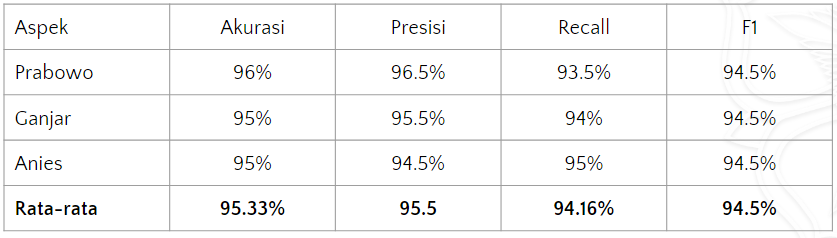

## Klasifikasi Sentimen

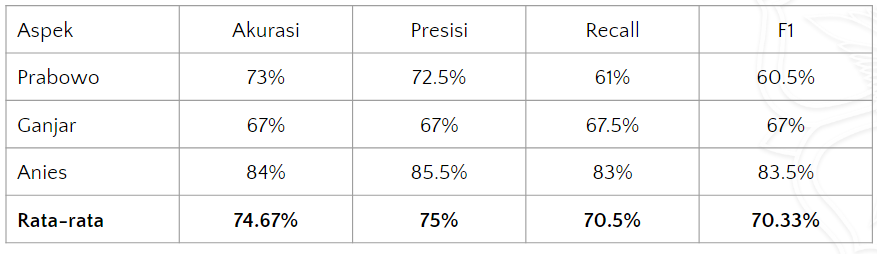